# Viego Data analysis

## Gathering data

All games with a Viego in it are stored in game_viego collection.

In [1]:
import pymongo

client = pymongo.MongoClient()
db = client.viego_2021
mongoTable = db["game_viego"]

Find the Viego player and look for the Dark Seal in his EoG items, then save the game data in memory.

In [2]:
games = []
for g in mongoTable.find({},{"gameId":1,"participants":1,"participantIdentities":1,"timeline":1,"queueId":1,"gameCreation":1}):
    
    for p in g["participants"]:
        # If the champion played if Viego
        if p["championId"] == 234:
            viego_pId = p["participantId"]
            
            # If Dark seal in EoG items
            if 1082 in [p["stats"]["item"+str(i)] for i in range(0,7)]:
                break
    
    seal_bought = False
    
    # Search for Dark Seal purchase by Viego player
    for frame in g["timeline"]["frames"]:
        for event in frame["events"]:
            if event["type"] == "ITEM_PURCHASED" and event["participantId"] == viego_pId:
                if event["itemId"] == 1082:
                    seal_bought = True
                    break
    
    # Save the game data in memory
    if seal_bought:
        games.append(g)
        

Setting static information

In [36]:
queue_types = {
    400:"Normal",
    420:"Ranked",
    430:"Normal",
    440:"Ranked",
    450:"ARAM",
    700:"Clash",
    830:"Coop vs AI",
    840:"Coop vs AI",
    850:"Coop vs AI",
    900:"URF",
    2000:"Tuto",
    2010:"Tuto",
    2020:"Tuto"
}

Gathering clean data about players abusing the bug, and their allies.

In [4]:
players_abusing = []
players_with = []
for g in games:
    
    # p["stats"]["totalDamageDealt"] < 0  is the way tto find the overflow unique to Dark Seal Viego bug
    # Finding the teams with a Viego abuser, as there can be one in each team
    teams_with_viego_abuser = set([p["teamId"] for p in g["participants"] if p["championId"] == 234 and p["stats"]["totalDamageDealt"] < 0])
    
    # Linkg accountId to participantId
    participant_accountId = {}
    for p in g["participantIdentities"]:
        participant_accountId[p["participantId"]] = p["player"]["currentAccountId"]
        
    for p in g["participants"]:
        # Viego abusers
        if p["championId"] == 234 and p["stats"]["totalDamageDealt"] < 0:
            players_abusing.append({
                "gameId":g["gameId"],
                "win":p["stats"]["win"],
                "queueId":g["queueId"],
                "queueType":queue_types[g["queueId"]],
                "accountId":participant_accountId[p["participantId"]],
                "timestamp":g["gameCreation"]
            })
        #Viego abuser allies
        elif p["teamId"] in teams_with_viego_abuser:
            players_with.append({
                "gameId":g["gameId"],
                "win":p["stats"]["win"],
                "queueId":g["queueId"],
                "queueType":queue_types[g["queueId"]],
                "accountId":participant_accountId[p["participantId"]],
                "timestamp":g["gameCreation"]
            })
            

Putting everything into DataFrames

In [6]:
import pandas as pd
df_players_abusing = pd.DataFrame(players_abusing)
df_players_with = pd.DataFrame(players_with)

Getting the last time played for all considered accounts

In [7]:
from pantheon import pantheon
import asyncio

# Setting up Pantheon
server = "euw1"
api_key = "RGAPI-XXXX"

panth = pantheon.Pantheon(server, api_key)

# Listing all accountIds
accountIds = list(df_players_abusing["accountId"].unique())
accountIds += list(df_players_with["accountId"].unique())

# Setting up the dict for link accountId to last time played
last_game_timestamp_by_accountId = {}

# Calling the API
for accId in accountIds:
    try:
        last_game_timestamp_by_accountId[accId] = (await panth.getMatchlist(accId))["matches"][0]["timestamp"]
    except:
        accountIds.append(accId)

Getting bans and timestamp information information for all games

In [37]:
bans_all = []
for g in db["game_all"].find({},{"gameId":1,"queueId":1,"teams":1,"gameCreation":1}):
    if queue_types[g["queueId"]] == "Ranked":
        for t in g["teams"]:
            for ban in t["bans"]:
                bans_all.append({
                    "gameId":g["gameId"],
                    "championId":ban["championId"],
                    "timestamp":g["gameCreation"]
                })
df_bans_all = pd.DataFrame(bans_all)

In [38]:
all_timestamps = []
for g in mongoTable.find({},{"gameCreation":1}):
    all_timestamps.append(g["gameCreation"])

## Analyzing the data

### Games and players

First, simply take a look at the number of relevant games and accounts

In [8]:
len(df_players_abusing["gameId"].unique())

1032

In [11]:
len(df_players_abusing["accountId"].unique())

673

### Games distribution by queue

Getting the disttribution with value_counts()

In [12]:
df_players_abusing.drop_duplicates("gameId").sort_values("queueType")["queueType"].value_counts()

Ranked        519
Normal        379
Coop vs AI    134
Name: queueType, dtype: int64

Plotting the data into a pie chart

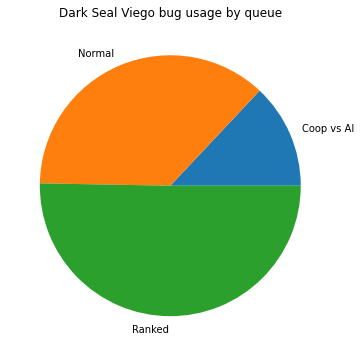

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor="w")

df_players_abusing.drop_duplicates("gameId").sort_values("queueType")["queueType"].value_counts().sort_index().plot.pie(ax=ax, figsize=(6,6))
ax.set_title('Dark Seal Viego bug usage by queue')
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

### Games per player

Here we will measure another metric, which is the number of games with the Viego bug, that each player played in

In [18]:
df_games_per_player = pd.DataFrame(
    [
        df_players_abusing.groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index(), 
        df_players_abusing[df_players_abusing["queueType"] == "Ranked"].groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()
    ], 
    index=["All", "Ranked"]
) \
.fillna(0) \
.astype(int).T

df_games_per_player

,All,Ranked
1,492,223
2,103,51
3,35,16
4,16,7
5,11,5
6,8,7
7,3,2
8,1,1
9,1,1
10,3,2


The index represents the number of games, and the value in the table, the number of games. For instance, 223 players used the bug only once in Ranked, and 3 players used it 10 times regardless of the queue.

We can do the same operation for the allied players

In [19]:
df_games_per_player_with = pd.DataFrame(
    [
        df_players_with.groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index(), 
        df_players_with[df_players_with["queueType"] == "Ranked"].groupby("accountId").count().sort_values("gameId", ascending=False)["gameId"].value_counts().sort_index()
    ], 
    index=["All", "Ranked"]
) \
.fillna(0) \
.astype(int).T

df_games_per_player_with

,All,Ranked
1,3614,1809
2,160,57
3,34,23
4,7,2
5,3,2
6,6,6
7,4,3
9,1,1


Of course, the number for playing once with an abuser is very high, but with high chance to be coincidence. With 2 or 3 games and more with an abuser, chances are very low that these players didn't intentionally queue up with an abuser.

Getting the table into markdown format with tabulate

In [20]:
from tabulate import tabulate
print(tabulate(df_games_per_player, tablefmt="pipe", headers="keys"))

|    |   All |   Ranked |
|---:|------:|---------:|
|  1 |   492 |      223 |
|  2 |   103 |       51 |
|  3 |    35 |       16 |
|  4 |    16 |        7 |
|  5 |    11 |        5 |
|  6 |     8 |        7 |
|  7 |     3 |        2 |
|  8 |     1 |        1 |
|  9 |     1 |        1 |
| 10 |     3 |        2 |


In [21]:
print(tabulate(df_games_per_player_with, tablefmt="pipe", headers="keys"))

|    |   All |   Ranked |
|---:|------:|---------:|
|  1 |  3614 |     1809 |
|  2 |   160 |       57 |
|  3 |    34 |       23 |
|  4 |     7 |        2 |
|  5 |     3 |        2 |
|  6 |     6 |        6 |
|  7 |     4 |        3 |
|  9 |     1 |        1 |


### Last time played

Including the alst time played in the players DataFrames

In [23]:
df_players_abusing["last_played"] = df_players_abusing["accountId"].map(lambda x:last_game_timestamp_by_accountId[x] if x in last_game_timestamp_by_accountId else 0)
df_players_with["last_played"] = df_players_with["accountId"].map(lambda x:last_game_timestamp_by_accountId[x] if x in last_game_timestamp_by_accountId else 0)

Finding the accounts who used the bug more than once

In [24]:
df_players_abusing_frequent = df_players_abusing[
    # Filter by the given accountIds
    df_players_abusing["accountId"].isin(
        # List the accountIds
        df_players_abusing.groupby("accountId").count()[
            # Accounts with more than one game
            df_players_abusing.groupby("accountId").count()["gameId"] > 1
        ].index.values
    )
].drop_duplicates("accountId")

Number of account not having played since March (timestamp : 1617228000000)

In [27]:
df_players_abusing_frequent[df_players_abusing_frequent["last_played"] < 1617228000000].shape[0]

69

In [29]:
df_players_abusing_frequent.shape[0]

181

69 out of 181 accounts

Same thing for 3 games or more

In [28]:
df_players_abusing_very_frequent = df_players_abusing[df_players_abusing["accountId"].isin(df_players_abusing.groupby("accountId").count()[df_players_abusing.groupby("accountId").count()["gameId"] > 2].index.values)].drop_duplicates("accountId")
df_players_abusing_very_frequent[df_players_abusing_very_frequent["last_played"] < 1617228000000].shape[0]

30

In [30]:
df_players_abusing_very_frequent.shape[0]

78

30 out of 78 accounts

### Games over time

Getting all timestamps over time as a base, and shifting everything to the earliuer timestamp

In [39]:
s_viego = pd.Series(all_timestamps)
s_viego_shifted = s_viego - s_viego.min()

All Viego games histogram, per 10 minutes over 2 days

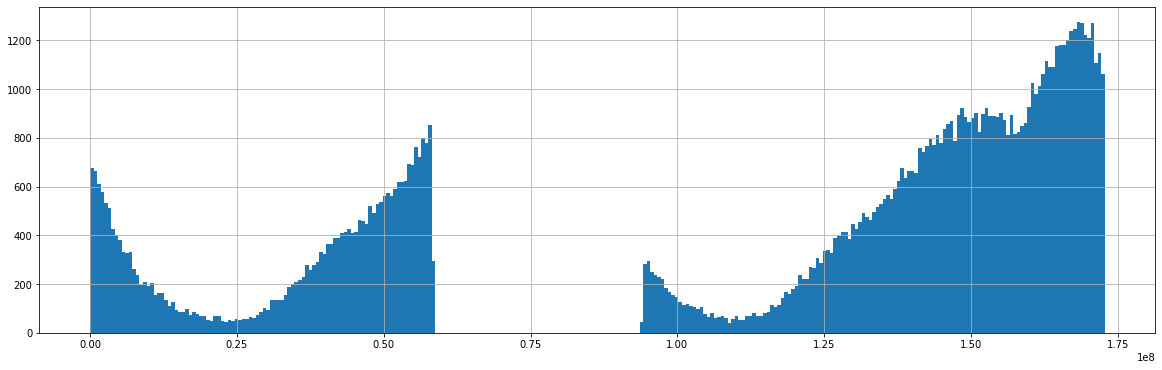

In [40]:
s_viego_shifted.hist(bins=6*24*2,figsize=(20,6))

This will be used as a base to plot everything else

Adding the games where the bug bug as been abused

In [42]:
s_ds_viego_shifted = df_players_abusing.drop_duplicates("gameId")["timestamp"] - s_viego.min()

(0.0, 175000000.0)

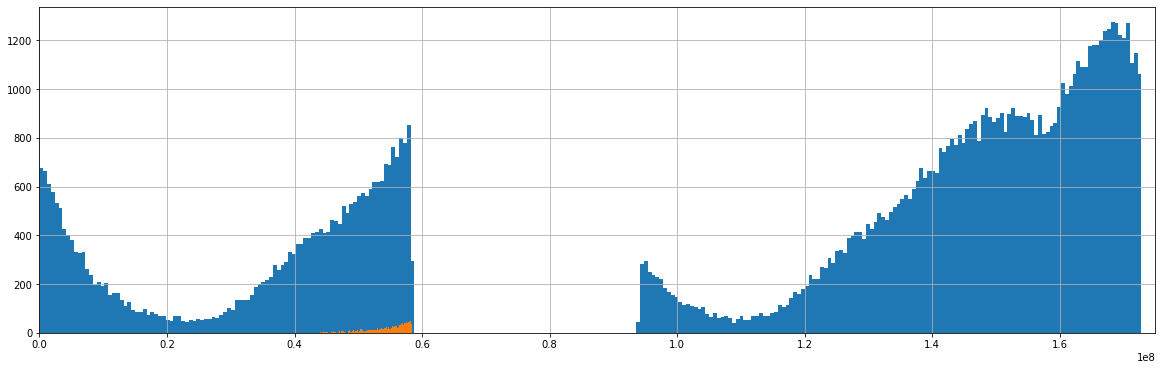

In [43]:
fig, ax = plt.subplots(facecolor="w")

s_viego_shifted.hist(bins=6*24*2,figsize=(20,6), ax=ax)
s_ds_viego_shifted.hist(bins=6*24*2,figsize=(20,6), ax=ax)
ax.set_xlim((0,175000000))

Creating a zoom on the part where Dark Seal Viego bug is raising

[]

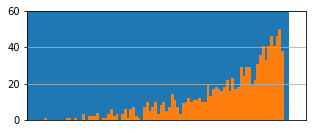

In [47]:
fig, ax = plt.subplots(facecolor="w")

s_viego_shifted.hist(bins=6*24*2,figsize=(5,2), ax=ax)
s_ds_viego_shifted.hist(bins=6*24*2,figsize=(5,2), ax=ax)
ax.set_xlim((40000000,60000000))
ax.set_ylim((0,60))

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels([])
ax.set_xticks([])

Preparing banrate data

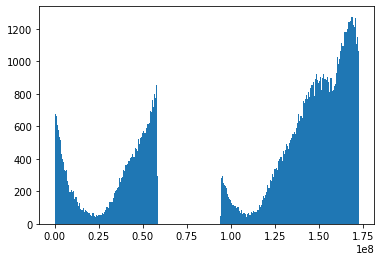

In [59]:
(n, bins, patches) = plt.hist(s_viego_shifted, bins=6*24*2)

df_bans_all["timestamp_shifted"] = df_bans_all["timestamp"] - s_viego.min()
df_bans_all["bins"] = pd.cut(df_bans_all["timestamp_shifted"],bins)
viego_banrate = (
    df_bans_all[df_bans_all["championId"] == 234].drop_duplicates("gameId").groupby("bins").count()["gameId"] 
    /
    df_bans_all.drop_duplicates("gameId").groupby("bins").count()["gameId"]
)
viego_banrate.index = viego_banrate.index.map(lambda x:x.mid)
viego_banrate.index = [float(i) for i in viego_banrate.index]

Plotting Viego banrate over time with rolling window

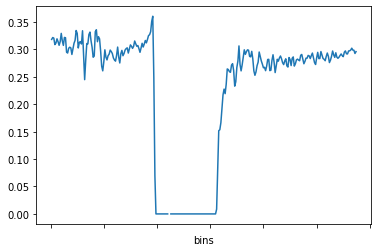

In [53]:
viego_banrate.rolling(window=2).mean().plot()

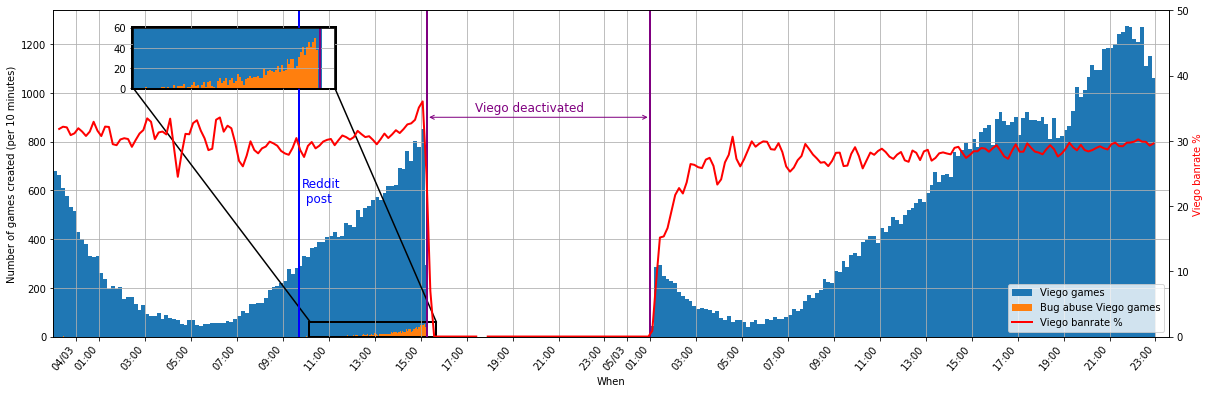

In [62]:
import matplotlib.patches as patches

fig, ax = plt.subplots(facecolor="w")

color="red"
color_zoom = "black"
color_viego = "purple"

# Games histograms
s_viego_shifted.hist(bins=6*24*2,figsize=(12,6), ax=ax, label="Viego games", xrot=50,)
s_ds_viego_shifted.hist(bins=6*24*2,figsize=(12,6), ax=ax, label="Bug abuse Viego games")
ax.set_xlim((0,175000000))

ax.set_ylabel("Number of games created (per 10 minutes)")
ax.set_xlabel("When")



# Zoomed part
axes = plt.axes([.18, .7, .14, .14])

s_viego_shifted.hist(bins=6*24*2,figsize=(5,2), ax=axes)
s_ds_viego_shifted.hist(bins=6*24*2,figsize=(5,2), ax=axes)
axes.set_xlim((40000000,60000000))
axes.set_ylim((0,60))
axes.axvline(x=58600000, color=color_viego, lw=2)

axes.set_ylabel("")
axes.set_xlabel("")
axes.set_xticklabels([])
axes.set_xticks([])

## Zoom lines
rect = patches.Rectangle((40000000, 0), 20000000, 60, linewidth=2, edgecolor=color_zoom, facecolor='none')
ax.add_patch(rect)

rect2 = patches.Rectangle((12240000, 1014), 32000000, 258, linewidth=2, edgecolor=color_zoom, facecolor='none')
ax.add_patch(rect2)

ax.plot([0.23, 0.073], [0.045, 0.755], transform=ax.transAxes, color=color_zoom)
ax.plot([0.343, 0.253], [0.045, 0.755], transform=ax.transAxes, color=color_zoom)


# Viego banrate plot
ax2 = ax.twinx()
viego_banrate_plot = (viego_banrate*100).rolling(window=2).mean().plot(ax=ax2, color=color, lw=2, label="Viego banrate %")
ax2.set_ylabel('Viego banrate %', color=color)
ax2.set_ylim((0,50))


# Custom label for time
ax.set_xticks([3600000] + [3600000*i*2 for i in range(1,13)] + [3600000*12.5*2] + [3600000*i*2 for i in range(13,25)], minor=False)
ax.set_xticklabels(["04/03","01:00","03:00","05:00","07:00","09:00","11:00","13:00",
                    "15:00","17:00","19:00","21:00","23:00","05/03","01:00","03:00","05:00","07:00","09:00","11:00","13:00",
                   "15:00","17:00","19:00","21:00","23:00"], ha="right")


# Additional information
# Viego disable time
ax.axvline(x=58600000, color=color_viego, lw=2)
ax.axvline(x=93500000, color=color_viego, lw=2)
ax.annotate(s='', xy=(93500000,900), xytext=(58600000,900), arrowprops=dict(arrowstyle='<->', color=color_viego))
ax.text(66050000, 925, "Viego deactivated", fontsize=12, color=color_viego)

# Reddit post
ax.axvline(x=38500000, color="blue", lw=2)
ax.text(39000000, 550, "Reddit\n post", fontsize=12, color="blue")

# Adding banrate plot to legend
handles, labels = ax.get_legend_handles_labels()
handles.append(viego_banrate_plot.get_lines()[0])
ax.legend(handles=handles, loc='lower right')

fig.set_size_inches(20,6)